In [1]:
from typing import cast, Callable, Dict, List, Optional, Tuple, Union
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.cs_vqe_tools as c_tools
import utils.linalg_tools as la
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator)

from openfermion.ops import FermionOperator
from qiskit_nature.operators.second_quantization.fermionic_op import FermionicOp

In [4]:
import numpy as np
import itertools
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

geometry=[['O',  [0.0000000,  0.0000000,    0.00000000]],
          ['H',  [0.0000000,  1.00000000,   0.0000000]],
          ['H',  [0.984807753,-0.1736481777,0.0000000]]]
charge=0
multiplicity=1
basis='sto-3g'

# construct with PySCF through openfermion for actual molecule calculations (including CC amps)
# Second quantised Hamiltonian:
molecule_data=MolecularData(geometry, basis, multiplicity, charge)
molecule=run_pyscf(molecule_data,run_scf=1,run_mp2=1,run_cisd=1,run_ccsd=1,run_fci=1)
ham_sq = get_fermion_operator(molecule.get_molecular_hamiltonian())
# Second quantised UCCSD operator:
num_electrons = molecule.n_electrons
num_qubits = 2*molecule.n_orbitals
ccsd_single_amps = molecule.ccsd_single_amps
ccsd_double_amps = molecule.ccsd_double_amps
packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
ucc_sq = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
num_qubits

C2v


14

In [5]:
# Duplicate in Qiskit Nature for purposes of determining tapering parameters
molecule_qiskit = Molecule(geometry=geometry, charge=charge, multiplicity=multiplicity) 
driver = ElectronicStructureMoleculeDriver(molecule_qiskit, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF)
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()

In [6]:
from qiskit.quantum_info.operators.symplectic.pauli import Pauli

In [21]:
# Map Hamiltonian and UCCSD operators from OpenFermion to Qiskit Nature representation
ham_sq_mapped = qonvert.fermionic_openfermion_to_qiskit(ham_sq, num_qubits)
ucc_sq_mapped = qonvert.fermionic_openfermion_to_qiskit(ucc_sq, num_qubits)

# Determine tapering stabilisers and correct sector with Qiskit Nature:
qubit_converter = QubitConverter(JordanWignerMapper(), z2symmetry_reduction='auto')
ham = qubit_converter.convert(ham_sq_mapped)
taper_qubits = qubit_converter.z2symmetries.sq_list
Z2sym = qubit_converter.z2symmetries.symmetries
Z2sec = [1, -1, -1, 1]#es_problem.symmetry_sector_locator(qubit_converter.z2symmetries)
hf_string = ''.join(['1' for i in range(int(num_qubits/2))])+''.join(['0' for i in range(int(num_qubits/2))])
hf_string_red = ''.join([hf_string[i] for i in range(num_qubits) if i not in taper_qubits])
hf_string_red

Z2sym, Z2sec, hf_string_red

([Pauli('IIIIZZIIIIIIII'),
  Pauli('ZIIZZIIZZIIZIZ'),
  Pauli('ZIZIZIZIZIZIZI'),
  Pauli('ZZIIIIIIZZIIII')],
 [1, -1, -1, 1],
 '1111000000')

In [11]:
from qiskit_nature.circuit.library.initial_states.hartree_fock import hartree_fock_bitstring
#hf_string = [True for i in range(int(num_qubits/2))]+[False for i in range(int(num_qubits/2))]
hf_string=hartree_fock_bitstring(num_particles=(molecule.get_n_alpha_electrons(),
                                                molecule.get_n_beta_electrons()),
                                num_spin_orbitals=2*molecule.n_orbitals)
hf_string

[True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False]

In [12]:
def pick_sector(Z2sym: List[Pauli], hf_str: List[bool]) -> List[int]:
    # Finding all the symmetries using the find_Z2_symmetries:
    taper_coeff: List[int] = []
    for sym in Z2sym:
        coeff = -1 if np.logical_xor.reduce(np.logical_and(sym.z[::-1], hf_str)) else 1
        taper_coeff.append(coeff)

    return taper_coeff

In [19]:
sectors = []
for c in list(itertools.combinations_with_replacement([+1, -1], 4)):
    sectors+=set(itertools.permutations(c))
sectors

[(1, 1, 1, 1),
 (-1, 1, 1, 1),
 (1, 1, 1, -1),
 (1, 1, -1, 1),
 (1, -1, 1, 1),
 (-1, 1, -1, 1),
 (-1, -1, 1, 1),
 (-1, 1, 1, -1),
 (1, -1, -1, 1),
 (1, 1, -1, -1),
 (1, -1, 1, -1),
 (-1, -1, -1, 1),
 (1, -1, -1, -1),
 (-1, 1, -1, -1),
 (-1, -1, 1, -1),
 (-1, -1, -1, -1)]

In [22]:
# Perform Jordan-Wigner transformation and taper
qubit_taper = QubitConverter(JordanWignerMapper(), z2symmetry_reduction=Z2sec)
ham_tap = qubit_taper.convert(ham_sq_mapped)
ucc_tap = qubit_taper.convert(ucc_sq_mapped)

pretap=la.get_ground_state(ham.to_spmatrix())[0]
postap=la.get_ground_state(ham_tap.to_spmatrix())[0]

print('Energy pre-tapering: ', pretap)
print('Energy post-tapering:', postap)
if postap-pretap<1e-5:
    print('Energies match, tapering successful')
else:
    print('Energy mismatch, incorrect sector selected')

Energy pre-tapering:  -75.02163993276577
Energy post-tapering: -75.02163993276504
Energies match, tapering successful
------------------------------------


In [25]:
ham_dict = {}
for op in ham_tap.to_pauli_op():
    ham_dict[str(op)[str(op).index('*')+2:]] = op.coeff
    
print(ham_dict)

{'IIIIIIIIII': -46.35562322894349, 'ZIIIIIIIII': 0.813128802779659, 'IZIIIIIIII': 0.8131288027796579, 'ZZIIIIIIII': 0.3084494928274998, 'IIZIIIIIII': 0.7955581721356351, 'ZIZIIIIIII': 0.11278411404149623, 'IZZIIIIIII': 0.14093041332535103, 'ZZZIIIIIII': 0.0, 'IIIZIIIIII': 0.7955581721356342, 'ZIIZIIIIII': 0.14093041332535103, 'IZIZIIIIII': 0.11278411404149623, 'IIZZIIIIII': 0.14941452041446, 'IIIIZIIIII': 2.730562415902313, 'ZIIIZIIIII': 0.3026418763036365, 'IZIIZIIIII': 0.3026418763036365, 'ZZIIZIIIII': 5.204170427930421e-18, 'IIZIZIIIII': 0.285652687565471, 'IIIZZIIIII': 0.28565268756547096, 'IIIIIZIIII': 1.291713616054491, 'ZIIIIZIIII': 0.13140842655865545, 'IZIIIZIIII': 0.1492038858132593, 'IIZIIZIIII': 0.11788087944015042, 'IZZIIZIIII': 2.2551405187698492e-17, 'IIIZIZIIII': 0.13779896932559016, 'IIIIZZIIII': 0.3442141180023776, 'IIZIZZIIII': -3.469446951953614e-18, 'ZIZIZZIIII': 0.0, 'IZZIZZIIII': 3.469446951953614e-17, 'ZZZIZZIIII': -3.469446951953614e-18, 'IIIIIIZIII': 1.2917136

In [26]:
ucc_dict = {}
for op in ucc_tap.to_pauli_op():
    ucc_dict[str(op)[str(op).index('*')+2:]] = op.coeff
print(ucc_dict)

{'ZXZZIZZIII': (8.131516293641283e-20+0j), 'ZYZZIZZIII': -0.0017756899344702484j, 'IXZZIZZZII': -8.131516293641283e-20j, 'IYZZIZZZII': 0.0017756899344702484j, 'ZXIZZIZIZI': (-2.710505431213761e-20+0j), 'ZYIZZIZIZI': (2.710505431213761e-20+0j), 'IXIZZIZZZI': -2.710505431213761e-20j, 'IYIZZIZZZI': (-2.710505431213761e-20+0j), 'XXIIIIIIII': 8.470329472543003e-22j, 'YXIIIIIIII': -4.953892155629169e-05j, 'XYIIIIIIII': -4.953892155629169e-05j, 'YYIIIIIIII': -8.470329472543003e-22j, 'XXIIIIIZII': (8.470329472543003e-22+0j), 'YXIIIIIZII': (8.470329472543003e-22+0j), 'XYIIIIIZII': (8.470329472543003e-22+0j), 'YYIIIIIZII': (-8.470329472543003e-22+0j), 'XXZIZZIIZI': 8.470329472543003e-22j, 'YXZIZZIIZI': (8.470329472543003e-22+0j), 'XYZIZZIIZI': (8.470329472543003e-22+0j), 'YYZIZZIIZI': -8.470329472543003e-22j, 'XXZIZZIZZI': (-8.470329472543003e-22+0j), 'YXZIZZIZZI': -4.953892155629169e-05j, 'XYZIZZIZZI': -4.953892155629169e-05j, 'YYZIZZIZZI': (8.470329472543003e-22+0j), 'XXIZZIZIIZ': (8.470329472

In [27]:
#from qiskit.opflow.primitive_ops.pauli_op import PauliOp 

#anz_dict = {}
#for op_list in anz_tap.to_pauli_op():
#    if type(op_list) == PauliOp:
#        op_list = [op_list]
#    for op in op_list:
#        try:
#            c = op.coeffs[0].real
#        except:
#            c = op.coeff
#        anz_dict[str(op)[str(op).index('*')+2:]] = c*1j
#
#print(anz_dict)

In [30]:
num_qubits

10

In [31]:
num_qubits  = ham_tap.num_qubits
ham         = ham_dict
uccsd       = ucc_dict
hf_config   = '1111000000'

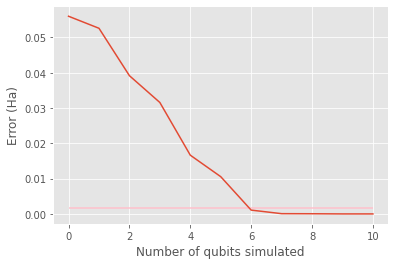

reaches chemical accuracy for 6-qubit CS-VQE


In [32]:
terms_noncon = greedy_dfs(ham, 1, criterion='size')[-1]
#terms_noncon = ['IIIIIIII', 'IZIZZZIZ', 'ZIZIZZZI', 'IIIIIZII', 'IIIIZIII', 'IZIIIIII', 'ZIIIIIII', 'IIIZIIII', 'IIZIIIII', 'ZZZZIIZZ', 'IIIIIIZI', 'IIIIIIIZ', 'IIIIZZII', 'IZIZIZIZ', 'IZIZZIIZ', 'ZIZIIZZI', 'ZIZIZIZI', 'IIIXIIZX', 'IIIYIIZY', 'IZIIIZII', 'IZIIZIII', 'ZIIIIZII', 'ZIIIZIII', 'IIIZIZII', 'IIIZZIII', 'IIZIIZII', 'IIZIZIII', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIZIIZ', 'IIIIZIZI', 'ZZIZZZIZ', 'ZZZIZZZI', 'IIIZZZIZ', 'IIZIZZZI', 'IZZZZZIZ', 'ZIZZZZZI', 'IZIIZZIZ', 'ZIIIZZZI', 'IZIZZZZZ', 'ZIZIZZZZ', 'ZZIIIIII', 'IZIZZZII', 'ZIZIZZII', 'IIZZIIII', 'IZZIIIII', 'ZIIZIIII', 'IIIIIIZZ', 'IZIIIIZI', 'ZIIIIIIZ', 'IIIZIIZI', 'IIZIIIIZ', 'IZIZIIII', 'ZIZIIIII', 'IZIIIIIZ', 'ZIIIIIZI', 'IIIZIIIZ', 'IIZIIIZI', 'IIIXIZZX', 'IIIXZIZX', 'IIIYIZZY', 'IIIYZIZY', 'ZIZXZZIX', 'ZIZYZZIY', 'IZIXZZZX', 'IZIYZZZY', 'ZIIXIIZX', 'ZIIYIIZY', 'IZIXIIZX', 'IZIYIIZY', 'IIZXIIZX', 'IIZYIIZY', 'IIIXIIIX', 'IIIYIIIY']
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)


mol_circ.plot_cs_vqe_errors()
num_sim_q = mol_circ.chem_acc_num_q
print('reaches chemical accuracy for %i-qubit CS-VQE' % (num_sim_q))

In [34]:
#num_sim_q=4
#anz_op_order_by_amp = list(list(zip(*sorted(uccsd.items(), key=lambda x: abs(x[1]))))[0])
#anz_op_order_by_amp.reverse()
#anz = {op:uccsd[op] for op in anz_op_order_by_amp[:100]}
anz = uccsd

ham_red = mol_circ.ham_reduced[num_sim_q]
anz_red = mol_circ.project_anz_terms(anz, num_sim_q)
#init_params = np.array([v.imag for v in anz_red.values()])
#bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])

#qc = mol_circ.build_circuit(anz, num_sim_q)
#qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
#qc.draw(output='mpl')

6-qubit reduced Hamiltonian: {'IIIIII': -72.10628359038024, 'ZIIIII': 0.21196400013832473, 'ZIIZII': -0.13401416733811145, 'IIIZII': 0.1789367776104591, 'ZZIZZI': -0.02751116978213717, 'IZIZZI': -0.11278411404149623, 'IZIIZI': 0.27667721968981585, 'ZZIIZI': 0.12460692210475054, 'ZIZZIZ': -0.010190752233265113, 'IIZZIZ': -0.14093041332535103, 'IIZIIZ': 0.2485313157472529, 'IZZIZZ': 0.14941452041446, 'IZIIII': 0.31910219648788946, 'ZZIIII': -0.13140842655865545, 'ZZIZII': 0.27725396558949117, 'ZIIZZI': 0.27238470987456037, 'IIIIZI': 0.6609860367630712, 'ZZZZIZ': 0.13779896932559016, 'IIIZZI': 0.12455565490286437, 'ZIIIZI': -0.1386792108758988, 'IIZIII': 0.33163183851842415, 'ZIZIII': -0.1492038858132593, 'ZIZZII': 0.25945852501597966, 'IIZZII': 0.1472736670377191, 'ZZZZZI': 0.13779896932559016, 'ZIIZIZ': 0.25656072396062096, 'IIIIIZ': 0.6960317178767705, 'IZZIII': 0.18845022565373157, 'IIZIZI': 0.1672139688184616, 'ZIZIIZ': 0.14192694433051598, 'IZIZII': 0.13474404367614826, 'ZIZZZZ': 0.

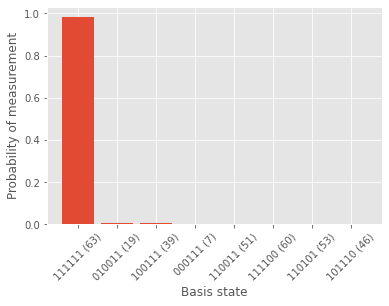

*   Performing 6-qubit CS-VQE over qubit positions 6, 4, 3, 2, 1, 0 ...


KeyboardInterrupt: 

In [36]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False)

title = '%i-qubit CS-VQE simulation' % (num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [38]:
ham_tap.num_qubits

10